# Library

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Input, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.dtypes import uint8, float32
from keras.layers import TFSMLayer
import pickle

In [12]:
from tensorflow.random import set_seed
set_seed(5)

Set the random seed for operations to 5 to ensures that any random operation (e.g., shuffling data, initializing weights in neural networks) produce the same results each time the code is run

# Data Loading and Preprocessing

In [13]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

# add 1 for label for true and 0 fro fake
true["label"] = 1
fake['label'] = 0

# Combine both dataframes and shuffle
input_data = pd.concat( [true,fake] )
input_data = input_data.sample(frac = 1)

# remove website url and ip
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", x))
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"^(?!mailto:)(?:(?:http|https|ftp)://)(?:\\S+(?::\\S*)?@)?(?:(?:(?:[1-9]\\d?|1\\d\\d|2[01]\\d|22[0-3])(?:\\.(?:1?\\d{1,2}|2[0-4]\\d|25[0-5])){2}(?:\\.(?:[0-9]\\d?|1\\d\\d|2[0-4]\\d|25[0-4]))|(?:(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)(?:\\.(?:[a-z\\u00a1-\\uffff0-9]+-?)*[a-z\\u00a1-\\uffff0-9]+)*(?:\\.(?:[a-z\\u00a1-\\uffff]{2,})))|localhost)(?::\\d{2,5})?(?:(/|\\?|#)[^\\s]*)?$", "", x))
input_data['text']= input_data['text'].apply(lambda x: re.sub(r"^((25[0-5]|(2[0-4]|1[0-9]|[1-9]|)[0-9])(\.(?!$)|$)){4}$", "", x))

In [14]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
input_data['text'] = input_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


The function of the step involving the removal of stopwords is to preprocess the text data by eliminating words that do not contribute significantly to the meaning or classification task. Stopwords are common words like "the," "is," "and," "in," etc., which appear frequently in natural language but usually do not carry much semantic weight.

In [15]:
#STEMMING
porter = PorterStemmer()
# for word in input_data['text']:
#     print(porter.stem(word))
input_data['text'] = input_data['text'].apply(lambda x: ' '.join([porter.stem(y) for y in x.split()]))

# Mapping Text to Vectors

In [16]:
# Tockenization
tokenizer = Tokenizer(num_words=9999999999)
tokenizer.fit_on_texts(input_data['text'])
sequences = tokenizer.texts_to_sequences(input_data['text'])
word_index = tokenizer.word_index

len(sequences)

#with open('tokenizer.pkl', 'wb') as f:
#    pickle.dump(tokenizer, f)

#print("Tokenizer saved successfully.")

44898

In [17]:
sequences=tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=100,
    dtype='int32',
    padding='post',
    truncating='pre',
    value=0.0
)

GLOVE_DIR = os.getcwd()

embeddings_index = {}

with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # The first value is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The rest are the coefficients (embeddings)
        embeddings_index[word] = coefs  # Add to dictionary
f.close()

In [18]:
print('Total %s word vectors in Glove.' % len(embeddings_index))

Total 400000 word vectors in Glove.


In [19]:
embedding_matrix = np.random.random((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix])

path = os.getcwd() + '/'
pickle.dump(embedding_layer, open(path + 'i100embedding_layer.pkl', 'wb'))

# Splitting the Data

In [20]:
data=sequences
label= input_data["label"]
x_train, x_test, y_train, y_test = train_test_split( data, label, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 35918 4490 4490
real & fake news in train,valt,test:
17094
2147
2176


In [ ]:
path = os.getcwd() + '/'
pickle.dump(x_train, open(path + 'x_train.pkl', 'wb'))
pickle.dump(y_train, open(path + 'y_train.pkl', 'wb'))
pickle.dump(y_test, open(path + 'y_test.pkl', 'wb'))
pickle.dump(x_test, open(path + 'x_test.pkl', 'wb'))
pickle.dump(x_val, open(path + 'x_val.pkl', 'wb'))
pickle.dump(y_val, open(path + 'y_val.pkl', 'wb'))

# Model

In [9]:
path = os.getcwd() + '/'
x_train=pickle.load(open(path+'x_train.pkl', 'rb'))
y_train=pickle.load(open(path+'y_train.pkl', 'rb'))
y_test=pickle.load(open(path+'y_test.pkl', 'rb'))
x_test=pickle.load(open(path+'x_test.pkl', 'rb'))
x_val=pickle.load(open(path+'x_val.pkl', 'rb'))
y_val=pickle.load(open(path+'y_val.pkl', 'rb'))
embedding_layer = pickle.load(open(path+'i100embedding_layer.pkl', 'rb'))

In [16]:
class myCallback(Callback):
    def __init__(self, model_name='CNN_LSTM', model_dir='./Models/CNN_LSTM_Models'):
        super(myCallback, self).__init__()
        self.model_name = model_name
        self.model_dir = model_dir
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)

    def on_train_end(self, logs=None):
        if logs is None:
            logs = {}
        
        model_path = os.path.join(self.model_dir, f"{self.model_name}.h5")  # Add .h5 extension
        self.model.save(model_path)  # Save the model in .h5 format
        print(f"Model saved at: {model_path} (HDF5 format)")

In [17]:
i = Input(shape=(100,), dtype='uint8')
x = embedding_layer(i)
x = Conv1D(128, 5, activation='relu')(x)
x= Dropout(0.30)(x)
x= BatchNormalization()(x)
x = MaxPool1D()(x)
x = LSTM(32, activation='linear')(x)
x= Dropout(0.30)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[i], outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model = Model(inputs=[i], outputs=output, name='CNN+LSTM')

model.summary()
callback = myCallback()

Model: "CNN+LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 300)            │      38,994,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,208,181 (149.57 MB)

 Trainable params: 39,207,925 (149.57 MB)

 Non-trainable params: 256 (1.00 KB)

In [17]:
BATCH_SIZE = 64
EPOCHS = 30
TRAINING_STEPS = len(x_train) // BATCH_SIZE
VALIDATION_STEPS = len(x_val) // BATCH_SIZE

history = model.fit(
    x_train, y_train,
    steps_per_epoch=TRAINING_STEPS,
    validation_data=(x_val, y_val),
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=[callback],
    verbose='auto'
)

pickle.dump(history.history, open('./Models/CNN_LSTM_Models/history_CNN_LSTM.pkl', 'wb'))

Epoch 1/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 125s 222ms/step - accuracy: 0.8349 - loss: 0.3752 - val_accuracy: 0.8811 - val_loss: 0.2824
Epoch 2/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 124s 222ms/step - accuracy: 0.8728 - loss: 0.3011
Epoch 3/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 125s 222ms/step - accuracy: 0.8970 - loss: 0.2572 - val_accuracy: 0.9216 - val_loss: 0.2048
Epoch 4/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 124s 222ms/step - accuracy: 0.9114 - loss: 0.2235
Epoch 5/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 124s 221ms/step - accuracy: 0.9225 - loss: 0.1960 - val_accuracy: 0.9330 - val_loss: 0.1762
Epoch 6/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 124s 220ms/step - accuracy: 0.9306 - loss: 0.1812
Epoch 7/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 125s 222ms/step - accuracy: 0.9408 - loss: 0.1554 - val_accuracy: 0.9445 - val_loss: 0.1465
Epoch 8/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 124s 221ms/step - accuracy: 0.9473 - loss: 0.1404
Epoch 9/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 125s 222ms/step - accuracy: 0.9514 - loss: 0.1267 - val_accuracy: 0.9421

Model saved at: ./Models/CNN_LSTM_Models\CNN_LSTM.h5 (HDF5 format)


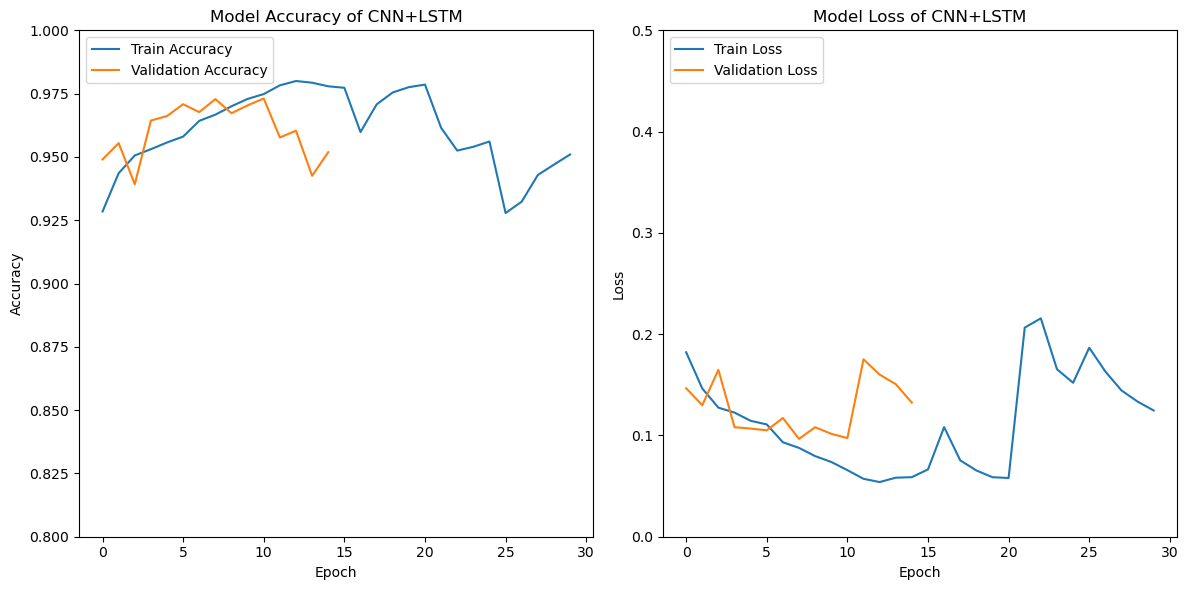

In [4]:
with open('./Models/CNN_LSTM_Models/history_CNN_LSTM.pkl', 'rb') as file:
    history = pickle.load(file)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
axs[0].plot(history['accuracy'], label='Train Accuracy')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy of CNN+LSTM')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0.8, 1)
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history['loss'], label='Train Loss')
axs[1].plot(history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss of CNN+LSTM')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 0.5)
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
saved_model_path = './Models/CNN_LSTM_Models/CNN_LSTM.h5'  

inference_model = tf.keras.models.load_model(saved_model_path)

In [10]:
y_pred = inference_model.predict(x_test)
y_pred = np.squeeze(y_pred)  

y_pred

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


array([1.2762500e-04, 3.2658067e-03, 1.5522491e-03, ..., 1.1436396e-05,
       8.7541598e-04, 9.9999982e-01], dtype=float32)

In [11]:
# Converting the predictions to binary using a threshold
p = lambda t: 1 if t >= 0.5 else 0
y_pred = np.vectorize(p)(y_pred)

In [12]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

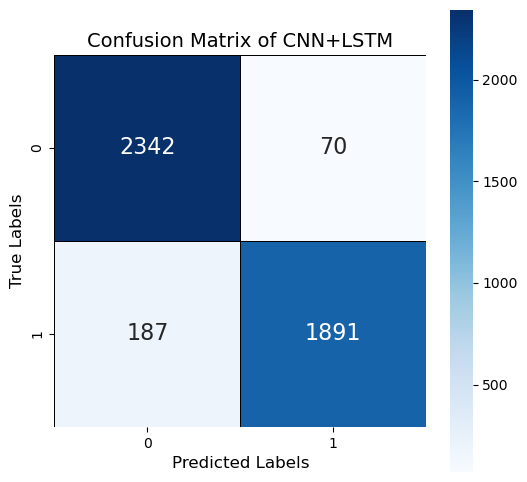

In [13]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black')

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix of CNN+LSTM', fontsize=14)
plt.show()


|   | Predicted: True News | Predicted: Fake News |
|---|----------------------|---------------------|
| **Actual: True News**    | 2,342 (TP)          | 70 (FN)             |
| **Actual: Fake News**    | 187 (FP)            | 1,891 (TN)           |

In [14]:
# Displaying performance metrics
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Accuracy: 0.943
Precision: 0.964
Recall: 0.910
F1 Score: 0.936


In [18]:
dot_img_dir = 'vis'
dot_img_file = os.path.join(dot_img_dir, 'model_1.png')

# Plot and save the model architecture to the specified file
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

print(f"Model architecture saved to: {dot_img_file}")

Model architecture saved to: vis\model_1.png
